In [107]:
# This script examines the UCI sanctioned racing calendar to look at global changes in the number of events.
# Source is https://www.uci.org/road/calendar, all categories/classes selected
# Year could be extracted from the start date, but UCI 'seasons' differ from calendar years
# for Africa, Asia and Oceania circuits, so when outputting new calendars, add the year as _2XXX before .xlsx
# The script will add the year as a new column.
%matplotlib inline

In [2]:
import pandas as pd
import glob
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
#Map the UCI Calendar excel output to the Continental circuits using the UCI's country names
continents = {'Americas': ['ANTIGUA AND BARBUDA', 'ARGENTINA', 'ARUBA', 'BELIZE', 'BERMUDA', 
                           'BOLIVARIAN REPUBLIC OF VENEZUELA', 'BOLIVIA', 'BRAZIL', 'CANADA',
                           'CHILE', 'COLOMBIA', 'CUBA', 'DOMINICAN REPUBLIC', 'ECUADOR', 
                           'EL SALVADOR', 'HONDURAS', 'PANAMA', 'PARAGUAY', 'PUERTO RICO', 
                           'SAINT VINCENT AND THE GRENADINES', 'TRINIDAD AND TOBAGO', 
                           'UNITED STATES OF AMERICA', 'URUGUAY','MEXICO', 'COSTA RICA','GUATEMALA'],
              'Africas' : ['ALBANIA', 'ALGERIA', 'ANGOLA', 'CAMEROON', 'CONGO', 'COTE D\'IVOIRE',
                           'EGYPT', 'ETHIOPIA', 'GUYANA', 'LIBYA', 'MALI', 'MAURITIUS', 'MOROCCO',
                           'NAMIBIA', 'RWANDA', 'SENEGAL', 'SOUTH AFRICA', 'SWAZILAND', 'TUNISIA', 
                           'UGANDA', 'ZIMBABWE', 'GABON','ERITREA', 'BURKINA FASO'],
              'Asia' : ['AZERBAIJAN', 'BAHRAIN', 'BRUNEI DARUSSALAM', 'CHINESE TAIPEI', 'GEORGIA',
                        'INDIA', 'ISLAMIC REPUBLIC OF IRAN', 'ISRAEL', 'KAZAKHSTAN', 'KOREA', 'KUWAIT', 
                        'KYRGYZSTAN', 'LEBANON', 'MALAYSIA', 'MONGOLIA', 'MYANMAR', 'OMAN', 'PHILIPPINES',
                        'RUSSIAN FEDERATION', 'SINGAPORE', 'SRI LANKA', 'SYRIAN ARAB REPUBLIC', 'THAILAND',
                        'TURKEY', 'UNITED ARAB EMIRATES', 'VIETNAM','HONG KONG, CHINA','QATAR', 'UZBEKISTAN',
                        'INDONESIA', 'JAPAN','PEOPLE\'S REPUBLIC OF CHINA'],
              'Europe' : ['AUSTRIA', 'BELARUS', 'BELGIUM', 'BOSNIA AND HERZEGOVINA', 'BULGARIA', 'CROATIA',
                          'CYPRUS', 'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 
                          'FORMER YUGOSLAV REPUBLIC OF MACEDONIA', 'FRANCE', 'GERMANY', 'GREAT BRITAIN', 
                          'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ITALY', 'KOSOVO', 'LATVIA', 'LITHUANIA',
                          'LUXEMBOURG', 'MONTENEGRO', 'NETHERLANDS', 'NORWAY', 'POLAND', 'PORTUGAL', 
                          'REPUBLIC OF MOLDOVA', 'ROMANIA', 'SAN MARINO', 'SERBIA', 
                          'SLOVAKIA', 'SLOVENIA', 'SWEDEN', 'SWITZERLAND', 'UKRAINE','SPAIN'],
              'Oceania' : ['NEW ZEALAND','AUSTRALIA']}

In [3]:
#Pull in every excel sheet from the current folder that starts with Calendar and ends in xlsx. YMMV!

all_data = pd.DataFrame()
for f in glob.glob('Calendar*.xlsx'):
    df = pd.read_excel(f, header=1, encoding='UTF-8')
    year = os.path.basename(f).split('.')[0].split('_')[-1]
    df['Season'] = year
    all_data = all_data.append(df,ignore_index=True)

In [4]:
#Examine the head and length to make sure it's kosher
# all_data['Class'].unique()
# array(['2.2', 'CRT', '2.HC', '2.1', '1.2', '1.1', 'CN', '2.UWT', '1.UWT',
#        '2.Ncup', '1.HC', 'CC', '1.WWT', '1.Ncup', '1.2U', '2.2U', 'JR',
#        '2.WWT', 'JC', 'CM', 'JOJ', 'CDM', nan, 'JO', 'CPE', 'MNM', 'AU1',
#        '2.CH', '1.CH', 'GT2', 'GT1'], dtype=object)

# I suspect there are some classes have changed over the years. MP is ME, CPE was WT stage races during dispute
# with ASO (2.UWT), MNM = Monument and CPE were WT one-days during disputed years (1.UWT) 
#Let's reassign them to current codes.
all_data['Category'].replace('MP', 'ME')
all_data['Class'].replace('CPE', '2.UWT')
all_data['Class'].replace(['MNM','AU1', '1.CH'], '1.UWT')
#Get rid of unwanted columns.
del all_data['EMail']
del all_data['WebSite']
del all_data['Calendar']
del all_data['Venue']
all_data.head()

,Date From,Date To,Name,Country,Category,Class,Season
0,24/10/2017,29/10/2017,Vuelta a Colombia Femenina Oro y Paz,COLOMBIA,WE,2.2,2018
1,23/10/2017,01/11/2017,Vuelta a Guatemala,GUATEMALA,ME,2.2,2018
2,04/11/2017,04/11/2017,Subaru Australian Open Criterium,AUSTRALIA,ME,CRT,2018
3,04/11/2017,04/11/2017,Le Tour De France Saitama Criterium,JAPAN,ME,CRT,2018
4,04/11/2017,04/11/2017,Subaru Australian Open Criterium,AUSTRALIA,WE,CRT,2018


In [5]:
#Need to rename the columns so they make sense and format the dates as dates
all_data = all_data.rename(columns={'Date From':'Start_date', 'Date To':'End_Date'})
all_data['Start_date'] = pd.to_datetime(all_data['Start_date'], dayfirst=True)
all_data['End_Date'] = pd.to_datetime(all_data['End_Date'], dayfirst=True)
all_data.head()

,Start_date,End_Date,Name,Country,Category,Class,Season
0,2017-10-24,2017-10-29,Vuelta a Colombia Femenina Oro y Paz,COLOMBIA,WE,2.2,2018
1,2017-10-23,2017-11-01,Vuelta a Guatemala,GUATEMALA,ME,2.2,2018
2,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,ME,CRT,2018
3,2017-11-04,2017-11-04,Le Tour De France Saitama Criterium,JAPAN,ME,CRT,2018
4,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,WE,CRT,2018


In [6]:
#Adding in a column for the length of the race in days

all_data['Race_Days'] = ((all_data['End_Date'] + pd.DateOffset(days=1)) - all_data['Start_date'])
all_data.head()


,Start_date,End_Date,Name,Country,Category,Class,Season,Race_Days
0,2017-10-24,2017-10-29,Vuelta a Colombia Femenina Oro y Paz,COLOMBIA,WE,2.2,2018,6 days
1,2017-10-23,2017-11-01,Vuelta a Guatemala,GUATEMALA,ME,2.2,2018,10 days
2,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,ME,CRT,2018,1 days
3,2017-11-04,2017-11-04,Le Tour De France Saitama Criterium,JAPAN,ME,CRT,2018,1 days
4,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,WE,CRT,2018,1 days


In [7]:
#Drop continental, world and national championships from the analysis
for x in ['CC', 'CM', 'CN']:
    row = (all_data.loc[all_data['Class'] == x]).sort_values(by='Season', ascending=0).iloc[0]
label = row.name
non_championships_df = all_data.drop(label)

non_championships_df.reset_index
non_championships_df.head()


,Start_date,End_Date,Name,Country,Category,Class,Season,Race_Days
0,2017-10-24,2017-10-29,Vuelta a Colombia Femenina Oro y Paz,COLOMBIA,WE,2.2,2018,6 days
1,2017-10-23,2017-11-01,Vuelta a Guatemala,GUATEMALA,ME,2.2,2018,10 days
2,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,ME,CRT,2018,1 days
3,2017-11-04,2017-11-04,Le Tour De France Saitama Criterium,JAPAN,ME,CRT,2018,1 days
4,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,WE,CRT,2018,1 days


In [8]:
#You can extract the year from the start date, but UCI 'seasons' differ from calendar years
# for Africa, Asia and Oceania circuits, so when outputting new calendars, add the year as _2XXX before .xlsx
# If you want you can just export the combined data

# all_data['Year'] = pd.DatetimeIndex(all_data['Date From']).year

# writer = pd.ExcelWriter('combined.xlsx')
# all_data.to_excel(writer,'Sheet1')

# writer.save()

In [9]:
#We need to make the dictionary of lists one big dictionary to add the Continents column

cont_dict_converted = {k: oldk for oldk, oldv in continents.items() for k in oldv}

#Note there are some events that cross borders or Continental championships that have no Continent.
#Add some code here to handle these cases.

non_championships_df['Continent'] = non_championships_df['Country'].map(cont_dict_converted).fillna('Stateless')


In [10]:
#Let's focus for now on the elite men and women's caregories in non-championship races

cats = ['ME', 'WE']
non_championships_df.Category.isin(cats)
elite_non_championships = non_championships_df[non_championships_df.Category.isin(cats)]
# group_cont = elite_non_championships.groupby("Continent")
# group_cont.count().head()

elite_non_championships.head()

,Start_date,End_Date,Name,Country,Category,Class,Season,Race_Days,Continent
0,2017-10-24,2017-10-29,Vuelta a Colombia Femenina Oro y Paz,COLOMBIA,WE,2.2,2018,6 days,Americas
1,2017-10-23,2017-11-01,Vuelta a Guatemala,GUATEMALA,ME,2.2,2018,10 days,Americas
2,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,ME,CRT,2018,1 days,Oceania
3,2017-11-04,2017-11-04,Le Tour De France Saitama Criterium,JAPAN,ME,CRT,2018,1 days,Asia
4,2017-11-04,2017-11-04,Subaru Australian Open Criterium,AUSTRALIA,WE,CRT,2018,1 days,Oceania


In [17]:
#add in the coordinates for each race so we can geolocate them on a map later

uci_country_coord = pd.DataFrame()
uci_country_coord = pd.read_excel('uci_country_coord.xlsx', encoding='UTF-8')
uci_df = pd.merge(elite_non_championships, uci_country_coord, right_on='uci_name', left_on='Country', how="left")
#Find which ones don't have coordinates...
df_nulls = uci_df[uci_df.isnull().any(axis=1)]
loc_nulls = df_nulls.groupby('Country')
loc_nulls['Country'].value_counts()
uci_df['Race_Days'] = pd.to_numeric(uci_df['Race_Days'])

In [18]:
# I cannot seem to get the inplace to work, and it's driving me crazy.

# uci_df.iloc[[415, 2005,6788,7243], 3:4].replace(to_replace='STATELESS', value='BELGIUM', inplace=True)
# uci_df.loc[uci_df['Name'] == 'Binck Bank Tour', :].replace(to_replace='STATELESS', value='BELGIUM', inplace=True)
uci_df.continent.unique()

array(['AMERICAS', 'OCEANIA', 'ASIA', 'AFRICA', 'EUROPE', nan],
      dtype=object)

In [19]:
data = uci_df.groupby(['Season','Continent']).sum()['Race_Days'].unstack()


<Figure size 432x288 with 0 Axes>

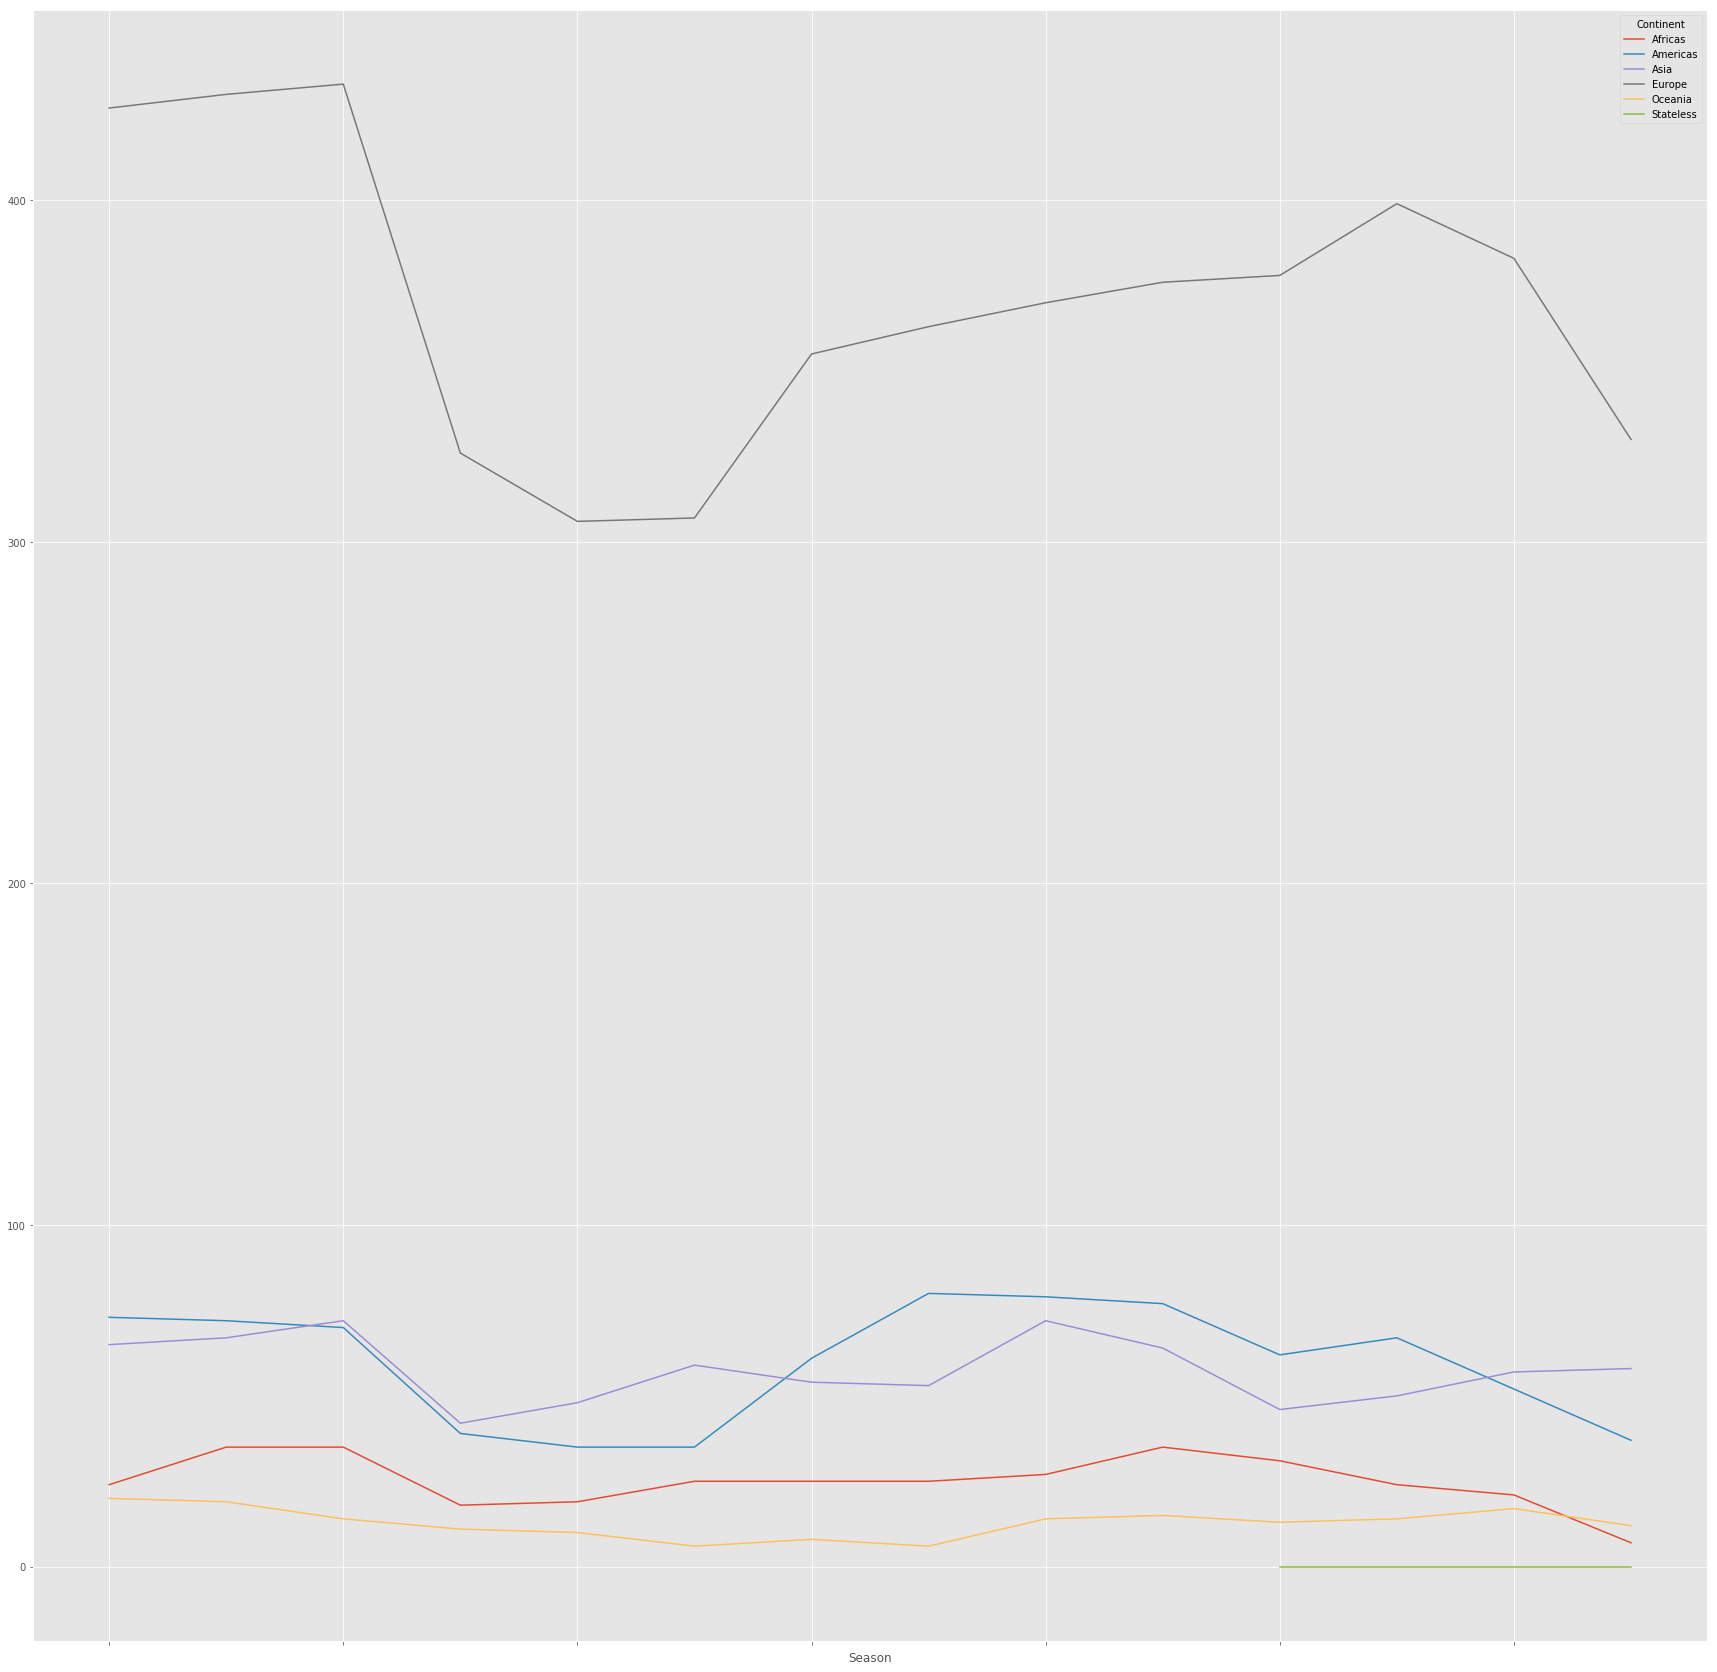

In [132]:
plt.figure()
data.plot(figsize=(30, 30))